In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt

In [12]:
class Image_Stitching:
    def __init__(self):
        self.ratio = 0.85
        self.min_match = 10
        self.sift = cv2.SIFT_create()
        self.smoothing_window_size = 800

    def apply_mask(self, img, mask):
        return cv2.bitwise_and(img, img, mask=mask)

    def blackout_masked_region(self, img, mask):
        img_blackout = img.copy()
        img_blackout[mask == 0] = 0
        return img_blackout

    def registration(self, img1, img2, mask1, mask2):
        masked_img1 = self.apply_mask(img1, mask1)
        masked_img2 = self.apply_mask(img2, mask2)

        kp1, des1 = self.sift.detectAndCompute(masked_img1, None)
        kp2, des2 = self.sift.detectAndCompute(masked_img2, None)

        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches = []
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])

        # Blackout masked regions for display
        img1_blackout = self.blackout_masked_region(img1, mask1)
        img2_blackout = self.blackout_masked_region(img2, mask2)

        img3 = cv2.drawMatchesKnn(img1_blackout, kp1, img2_blackout, kp2, good_matches, None, flags=2)
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.title('Matching')
        plt.show()

        if len(good_points) > self.min_match:
            image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
            return H
        else:
            return None

    def create_mask(self, img1, img2, version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask]).astype(np.float32)

    def blending(self, img1, img2, mask1, mask2):
        H = self.registration(img1, img2, mask1, mask2)
        if H is None:
            print("Not enough matches found between the images.")
            return None

        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        height_img2 = img2.shape[0]
        width_img2 = img2.shape[1]
        height_panorama = max(height_img1, height_img2)
        width_panorama = width_img1 + width_img2

        # Convert masks to uint8
        mask1 = mask1.astype(np.uint8)
        mask2 = mask2.astype(np.uint8)

        # Warp only the segmented regions of img2
        warped_img2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)).astype(np.float32)
        warped_mask2 = cv2.warpPerspective(mask2, H, (width_panorama, height_panorama)).astype(np.uint8)

        # Create blended panorama
        panorama1 = np.zeros((height_panorama, width_panorama, 3), dtype=np.float32)
        mask1_applied = self.apply_mask(img1, mask1).astype(np.float32)
        panorama1[0:height_img1, 0:width_img1] = mask1_applied

        mask1_blend = self.create_mask(img1, img2, version='left_image')
        panorama1 *= mask1_blend

        panorama2 = np.zeros((height_panorama, width_panorama, 3), dtype=np.float32)
        mask2_applied = self.apply_mask(warped_img2.astype(np.uint8), warped_mask2).astype(np.float32)
        panorama2 = mask2_applied

        mask2_blend = self.create_mask(img1, img2, version='right_image')
        panorama2 *= mask2_blend

        result = panorama1 + panorama2

        # Crop the resulting panorama to remove black borders
        rows, cols = np.where(np.any(result != 0, axis=-1))
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :].astype(np.uint8)

        return final_result

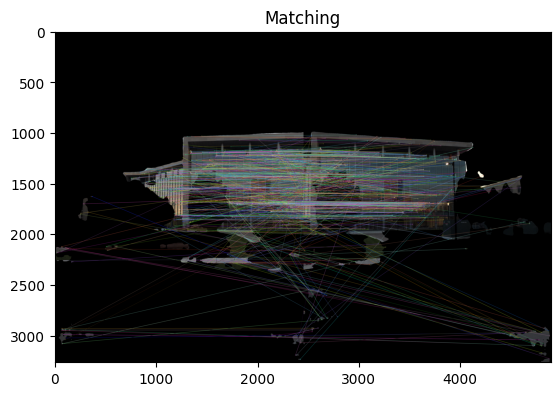

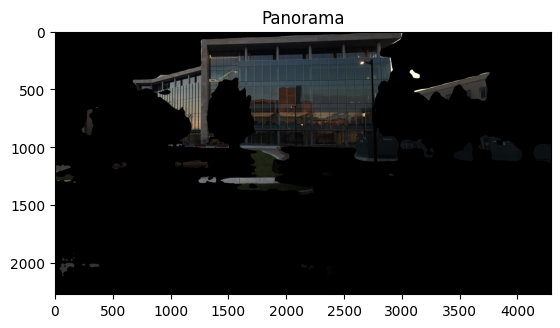

In [13]:
# Load images and masks
img1_path = 'image1.jpg'
img2_path = 'image2.jpg'
mask1_path = 'SETR_result/image1/mask_class_2.png'
mask2_path = 'SETR_result/image2/mask_class_2.png'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)

# Perform stitching
stitcher = Image_Stitching()
final = stitcher.blending(img1, img2, mask1, mask2)

if final is not None:
    # Save and display the result
    cv2.imwrite('panorama.jpg', final)
    plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    plt.title('Panorama')
    plt.show()
else:
    print("Image stitching failed.")